In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(18981, 24)
(18981, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_FR_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FR_swinging = Y_footsteps_accelerations_absolute[idxs]

## Predict FR foot -> x

In [8]:
X_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.02925825,  0.01290209,  0.0145091 ,  0.01718734,
        0.24676163,  0.13144901, -0.38242608,  0.23224038, -0.12821306,
       -0.38609892, -0.26756632,  0.12496905, -0.39002576, -0.25319165,
       -0.12552589, -0.38698047,  0.        ,  1.        ])

In [9]:
Y_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 3.76987239e-02, -2.84286750e-03,  3.80168041e-02, -5.36085384e-05])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # previous reference velocity,
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # current reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9934662426427759
RMSE:  0.017822132366590276
The lowest error is:  2.8233778940123244e-05
The highest error is:  0.0689278773163422
The avg. error is:  0.012693251564885344


In [12]:
model_fr_relative_swinging_x.coef_

array([[ 0.12058061,  0.04052996,  0.37333293,  0.01966696,  0.10775982,
        -1.54042714,  0.41545651,  0.28988817, -0.03052201, -0.76595059,
        -0.88297853]])

In [13]:
model_fr_relative_swinging_x.intercept_

array([0.169984])

Text(0, 0.5, 'Predictions')

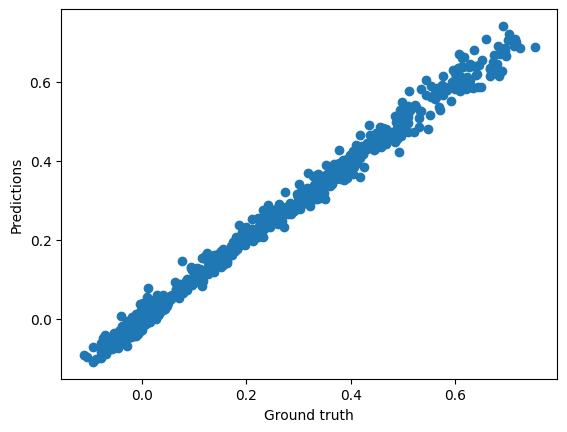

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]}->{X_test[idx, 1]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # previous reference velocity,
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # current reference velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_FR_swinging[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9099304667284177
RMSE:  0.009190189333028053
The lowest error is:  9.915223138853846e-07
The highest error is:  0.032271361469635135
The avg. error is:  0.006935643086202314


In [17]:
model_fr_relative_swinging_y.coef_

array([[-0.00185444,  0.01563072, -0.08602507, -0.54807157,  0.30734842,
        -0.47104925, -1.62064904,  0.38076756, -0.2293023 ,  0.97497215,
         0.70241665]])

In [18]:
model_fr_relative_swinging_y.intercept_

array([0.46365326])

Text(0, 0.5, 'Predictions')

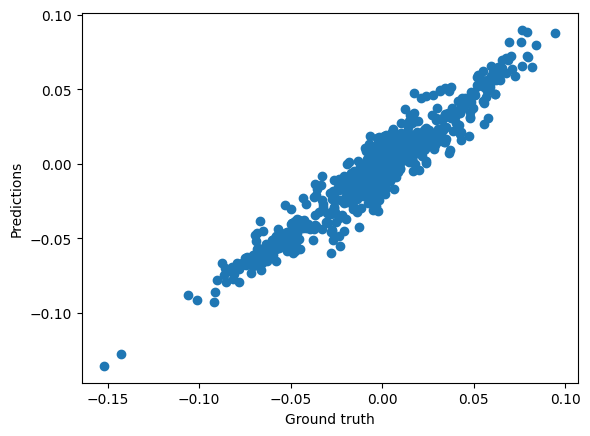

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [36]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')